In [1]:
import sys
import os

denoising_root_path = '/home/joy/project_repos/denoising/'
difface_path = denoising_root_path + '/open_source/DifFace/'

sys.path.append(denoising_root_path)
sys.path.append(difface_path)

print('Updated sys.path:', sys.path)

Updated sys.path: ['/home/joy/project_repos/denoising', '/home/joy/miniconda3/envs/denoising_cuda118/lib/python38.zip', '/home/joy/miniconda3/envs/denoising_cuda118/lib/python3.8', '/home/joy/miniconda3/envs/denoising_cuda118/lib/python3.8/lib-dynload', '', '/home/joy/miniconda3/envs/denoising_cuda118/lib/python3.8/site-packages', '/home/joy/project_repos/denoising/', '/home/joy/project_repos/denoising//open_source/DifFace/']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import glob
import time
import math
import pickle as pkl
import torchvision as thv

from math import ceil
from omegaconf import OmegaConf
from sampler import BaseSampler
from utils import util_common
from utils import util_image
from torch.utils import data

from skimage.metrics import structural_similarity

/home/joy/miniconda3/envs/denoising_cuda118/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def metrics_ssim(img1, img2):
    # apply max projection
    img1, img2 = np.max(img1, axis=0), np.max(img2, axis=0)
    data_range = max(np.max(img1), np.max(img2)) - min(np.min(img1), np.min(img2))
    # data_range = np.max(img1) - np.min(img1)
    # data_range = np.max(img2) - np.min(img2)
    (score, diff) = structural_similarity(img1, img2, full=True, data_range=data_range)
    return score

# Setup

In [4]:
%%time
# load val data
train_data_npz = '/home/sivark/supporting_files/denoising/data/planaria/Denoising_Planaria/train_data/data_label.npz'
noisy_key = 'X'
clean_key = 'Y'
noisy_data = np.load(train_data_npz)[noisy_key]
clean_data = np.load(train_data_npz)[clean_key]
split_fpth = '/home/sivark/supporting_files/denoising/trained_models/planaria_Train2TrainValTestv2.pkl'
split_to_infer = 'val_idx'
with open(split_fpth, 'rb') as pkl_f:
    splits = pkl.load(pkl_f)
noisy_data_val = noisy_data[splits['val_idx']].squeeze(axis=1)
clean_data_val = clean_data[splits['val_idx']].squeeze(axis=1)

CPU times: user 4.75 s, sys: 3.86 s, total: 8.61 s
Wall time: 9.69 s


In [5]:
noisy_data_val.shape, clean_data_val.shape

((1790, 16, 64, 64), (1790, 16, 64, 64))

In [6]:
%%time
# load N2V only results (should exactly correspond to val set above)
n2v_outputs_npz = '/home/sivark/supporting_files/denoising/data/planaria/Denoising_Planaria/Train2TrainValTest_pred/n2v_pred_Train2TrainValTest_val_idxv2.npz'
n2v_outputs_val = np.load(n2v_outputs_npz)['pred']

CPU times: user 2.56 s, sys: 190 ms, total: 2.75 s
Wall time: 3.18 s


In [7]:
n2v_outputs_val.shape

(1790, 16, 64, 64)

In [8]:
%%time
# load diffusion without mixing results (should exactly correspond to val set above)
nomix_outputs_npz = '/home/sivark/supporting_files/denoising/data/planaria/Denoising_Planaria/Train2TrainValTest_pred/Diff_pred_Train2TrainValTest_val_idx_t100.npz'
nomix_outputs_val = np.load(nomix_outputs_npz)['pred']

CPU times: user 2.71 s, sys: 138 ms, total: 2.85 s
Wall time: 2.93 s


In [9]:
nomix_outputs_val.shape

(1790, 16, 64, 64)

In [10]:
%%time
# load diffusion with mixing with N2V results (should exactly correspond to val set above)
mix_n2v_outputs_npz = '/home/joy/project_repos/denoising/data/planaria/Denoising_Planaria/Train2TrainValTest_pred/Diff_mixing_clean_pred_Train2TrainValTest_val_idx_t100.npz'
mix_n2v_outputs_val = np.load(mix_n2v_outputs_npz)['pred']

CPU times: user 2.68 s, sys: 157 ms, total: 2.84 s
Wall time: 3.32 s


In [11]:
mix_n2v_outputs_val.shape

(1790, 16, 64, 64)

In [12]:
# select a single image for testing
np.random.seed(0)
sample_idxs = np.random.choice(noisy_data_val.shape[0], size=1, replace=False)
print(sample_idxs)
noisy_data_sample = noisy_data_val[sample_idxs]
clean_data_sample = clean_data_val[sample_idxs]
nomix_data_sample = nomix_outputs_val[sample_idxs]
n2v_data_sample = n2v_outputs_val[sample_idxs]
mix_n2v_data_sample = mix_n2v_outputs_val[sample_idxs]
noisy_data_sample.shape, clean_data_sample.shape, nomix_data_sample.shape, n2v_data_sample.shape, mix_n2v_data_sample.shape

[1465]


((1, 16, 64, 64),
 (1, 16, 64, 64),
 (1, 16, 64, 64),
 (1, 16, 64, 64),
 (1, 16, 64, 64))

# Compare results from mixing vs no mixing

This code tests whether mixing affects the results.

In [13]:
def plot_compare(noisy, denoised_without_mixing, denoised_with_mixing_n2v, denoised_n2v, gt):
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    ax[0].imshow(noisy)
    ax[1].imshow(denoised_without_mixing)
    ax[2].imshow(denoised_with_mixing_n2v)
    ax[3].imshow(denoised_n2v)
    ax[4].imshow(gt)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    ax[0].set_title('noisy')
    ax[1].set_title('denoised_without_mixing')
    ax[2].set_title('denoised_with_mixing_n2v')
    ax[3].set_title('denoised_n2v')
    ax[4].set_title('gt')

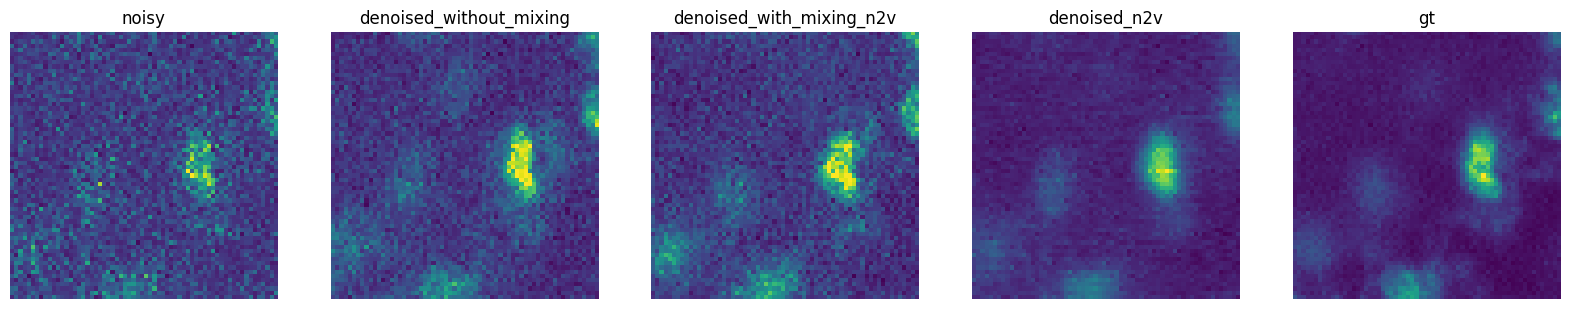

In [14]:
z = 8
plot_compare(
    noisy_data_sample[0,z,:,:],
    nomix_data_sample[0,z,:,:],
    mix_n2v_data_sample[0,z,:,:],
    n2v_data_sample[0,z,:,:],
    clean_data_sample[0,z,:,:],
)

In [15]:
print('SSIM noisy:', metrics_ssim(noisy_data_sample[0], clean_data_sample[0]))
print('SSIM diffusion without mixing:', metrics_ssim(nomix_data_sample[0], clean_data_sample[0]))
print('SSIM diffusion with mixing n2v:', metrics_ssim(mix_n2v_data_sample[0], clean_data_sample[0]))
print('SSIM N2V:', metrics_ssim(n2v_data_sample[0], clean_data_sample[0]))

SSIM noisy: 0.3358976102833878
SSIM diffusion without mixing: 0.5588796068042158
SSIM diffusion with mixing n2v: 0.5750500589303781
SSIM N2V: 0.6466849456706243


Text(0, 0.5, 'pixel value (with mixing n2v)')

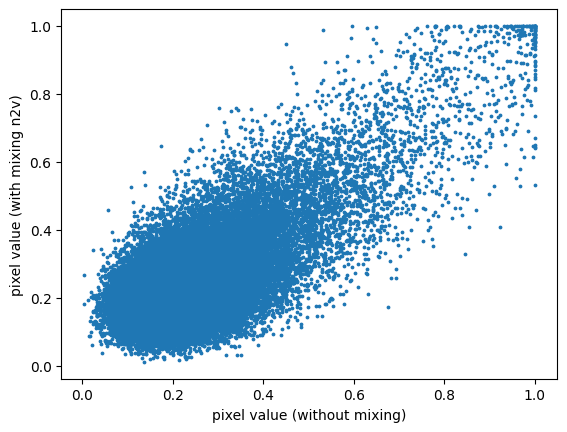

In [16]:
# correlate pixel values
plt.scatter(nomix_data_sample.flatten(), mix_n2v_data_sample.flatten(), s=3)
plt.xlabel('pixel value (without mixing)')
plt.ylabel('pixel value (with mixing n2v)')

# Repeat with other input images

In [18]:
sample_idxs = np.random.choice(noisy_data_val.shape[0], size=10, replace=False)
for sample_idx in sample_idxs:
    print('Val index:', sample_idx)
    noisy_data_sample = noisy_data_val[sample_idx][np.newaxis,]
    nomix_data_sample = nomix_outputs_val[sample_idx][np.newaxis,]
    mix_n2v_data_sample = mix_n2v_outputs_val[sample_idx][np.newaxis,]
    print('Outputs match:', np.allclose(nomix_data_sample, mix_n2v_data_sample))
    print()

Val index: 386
Outputs match: False

Val index: 738
Outputs match: False

Val index: 1523
Outputs match: False

Val index: 589
Outputs match: False

Val index: 241
Outputs match: False

Val index: 737
Outputs match: False

Val index: 42
Outputs match: False

Val index: 164
Outputs match: False

Val index: 456
Outputs match: False

Val index: 1708
Outputs match: False

